In [1]:
%load_ext autoreload
%autoreload 2
import sys, os

In [2]:
# !cp -r /home/hl5438/mcvd-pytorch /scratch/hl5438

In [3]:
import glob, os
import mediapy as media
import torch
from torch.utils.data import DataLoader
import numpy as np
from load_model_from_ckpt import load_model, get_sampler, init_samples
from datasets import get_dataset, data_transform, inverse_data_transform
from runners.ncsn_runner import conditioning_fn

from os.path import expanduser
home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
import yaml
import argparse

def to_namespace(d):
    if isinstance(d, dict):
        return argparse.Namespace(**{k: to_namespace(v) for k, v in d.items()})
    return d

def load_config(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return to_namespace(config_dict)

config = load_config('/home/hl5438/mcvd-pytorch/configs/VIT_64.yml')

In [16]:
config.data.num_frames

2

In [17]:
dataset, test_dataset = get_dataset('/scratch/hl5438/Dataset_Student', config, video_frames_pred=config.data.num_frames)

train set: 12996
test set: 1000


In [18]:
test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
print(test_x.shape)

torch.Size([64, 12, 3, 64, 64])


In [19]:
test_x = data_transform(config, test_x)
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
print(real.shape, cond.shape)

torch.Size([64, 24, 32, 32]) torch.Size([64, 120, 32, 32])


In [ ]:
ckpt_path='/scratch/hl5438/mcvd-pytorch/VIT_test_sp/logs/checkpoint.pt'
scorenet, config = load_model(ckpt_path, device)
sampler = get_sampler(config)

In [10]:
print(device)
print(ckpt_path)
print(config)

cuda
/scratch/hl5438/mcvd-pytorch/VIT_test_sp/logs/checkpoint.pt
Namespace(training=Namespace(L1=False, batch_size=64, n_epochs=50000, n_iters=10000001, snapshot_freq=10000, snapshot_sampling=True, sample_freq=10000, val_freq=1000, log_freq=100, log_all_sigmas=False), sampling=Namespace(batch_size=100, data_init=False, ckpt_id=0, final_only=True, fid=False, ssim=True, fvd=True, denoise=True, subsample=100, num_samples4fid=10000, num_samples4fvd=10000, inpainting=False, interpolation=False, n_interpolations=15, consistent=True, step_lr=0.0, n_steps_each=0, train=False, num_frames_pred=11, clip_before=True, max_data_iter=100000, init_prev_t=-1.0, one_frame_at_a_time=False, preds_per_test=1), fast_fid=Namespace(batch_size=1000, num_samples=1000, begin_ckpt=5000, freq=5000, end_ckpt=300000, pr_nn_k=3, verbose=False, ensemble=False, step_lr=0.0, n_steps_each=0), test=Namespace(begin_ckpt=5000, end_ckpt=50000, batch_size=100), data=Namespace(dataset='VIT_dataset', image_size=32, logit_transf

In [11]:
dataset, test_dataset = get_dataset('/scratch/hl5438/Dataset_Student', config, video_frames_pred=config.data.num_frames)

train set: 12996
test set: 1000


In [12]:
test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
print(test_x.shape)

torch.Size([64, 12, 3, 32, 32])


In [13]:
test_x = data_transform(config, test_x)
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
print(real.shape, cond.shape)

torch.Size([64, 6, 32, 32]) torch.Size([64, 30, 32, 32])


,,,,,,,,,

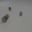
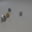
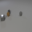
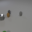
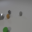
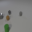
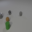
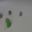
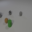
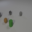

In [14]:
i = 1
cond_data=cond[i].reshape(10, 3, 32, 32).permute(0, 2, 3, 1)
media.show_images(cond_data)

,

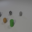
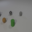

In [15]:
real_data=real[i].reshape(2, 3, 32, 32).permute(0, 2, 3, 1)
media.show_images(real_data)

In [16]:
init = init_samples(len(real), config)

torch.Size([64, 6, 32, 32])


,,,,,

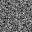
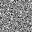
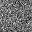
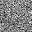
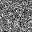
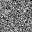

In [33]:
print(init.shape)
media.show_images(init[i])

In [34]:
pred = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=100, verbose=True)

DDPM: 1/100, grad_norm: 80.55826568603516, image_norm: 70.88117980957031, grad_mean_norm: 101.66580963134766
DDPM: 10/100, grad_norm: 80.05950927734375, image_norm: 70.99594116210938, grad_mean_norm: 101.8137435913086
DDPM: 20/100, grad_norm: 79.84248352050781, image_norm: 71.0905990600586, grad_mean_norm: 101.46222686767578
DDPM: 30/100, grad_norm: 79.97871398925781, image_norm: 70.77506256103516, grad_mean_norm: 99.20507049560547
DDPM: 40/100, grad_norm: 80.33043670654297, image_norm: 70.08006286621094, grad_mean_norm: 99.87577819824219
DDPM: 50/100, grad_norm: 81.99784088134766, image_norm: 68.16439819335938, grad_mean_norm: 97.51505279541016
DDPM: 60/100, grad_norm: 87.28131103515625, image_norm: 64.43685913085938, grad_mean_norm: 98.73116302490234
DDPM: 70/100, grad_norm: 99.7700424194336, image_norm: 58.0661735534668, grad_mean_norm: 100.06090545654297
DDPM: 80/100, grad_norm: 130.1883544921875, image_norm: 48.94190979003906, grad_mean_norm: 99.24889373779297
DDPM: 90/100, grad_n

torch.Size([64, 6, 32, 32])


,,,,,,,,,,,

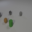
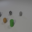
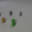
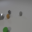
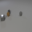
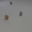
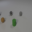
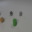
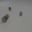
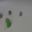
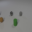
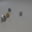

,,,,,,,,,,,

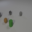
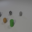
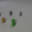
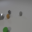
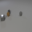
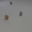
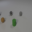
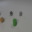
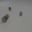
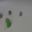
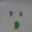
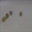

In [36]:
print(pred.shape)
i = 1
cond_data=cond[i].reshape(10, 3, 32, 32).permute(0, 2, 3, 1)
real_data=real[i].reshape(2, 3, 32, 32).permute(0, 2, 3, 1)
pred_data=pred[i].reshape(2, 3, 32, 32).permute(0, 2, 3, 1)
media.show_images(torch.cat([cond_data, real_data]))
media.show_images(torch.cat([cond_data, pred_data]))

In [ ]:
i = 4
cond_data=cond[i].reshape(10, 3, 32, 32).permute(0, 2, 3, 1)
real_data=real[i].reshape(2, 3, 32, 32).permute(0, 2, 3, 1)
pred_data=pred[i].reshape(2, 3, 32, 32).permute(0, 2, 3, 1)
media.show_images(torch.cat([cond_data, real_data]))
media.show_images(torch.cat([cond_data, pred_data]))